## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images
###Camera Calibration

####1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook located in "P4.ipynb" 

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  


In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def camera_calib():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

mtx,dist = camera_calib()

print('mtx: ', mtx)
print('dist: ', dist)



mtx:  [[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist:  [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]


## Provide an example of a distortion corrected calibration image.
I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

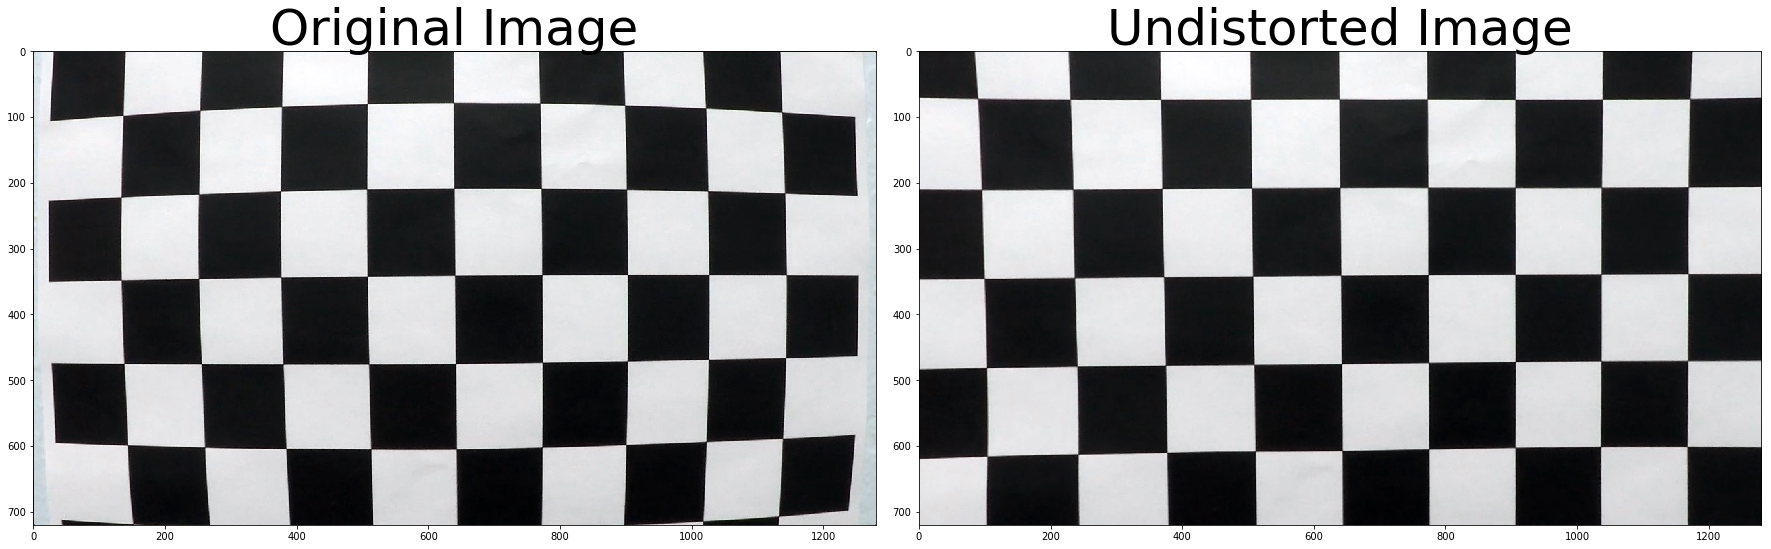

In [4]:
def cal_undistort(img, mtx, dist):
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist

img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perform color transforms and gradients to create a thresholded binary image.  
###Pipeline (single image)

####2. Here I applied the color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image. Here's an example of my output for this step.  (note: this is actually from one of the test images: test_images/test5.jpg)

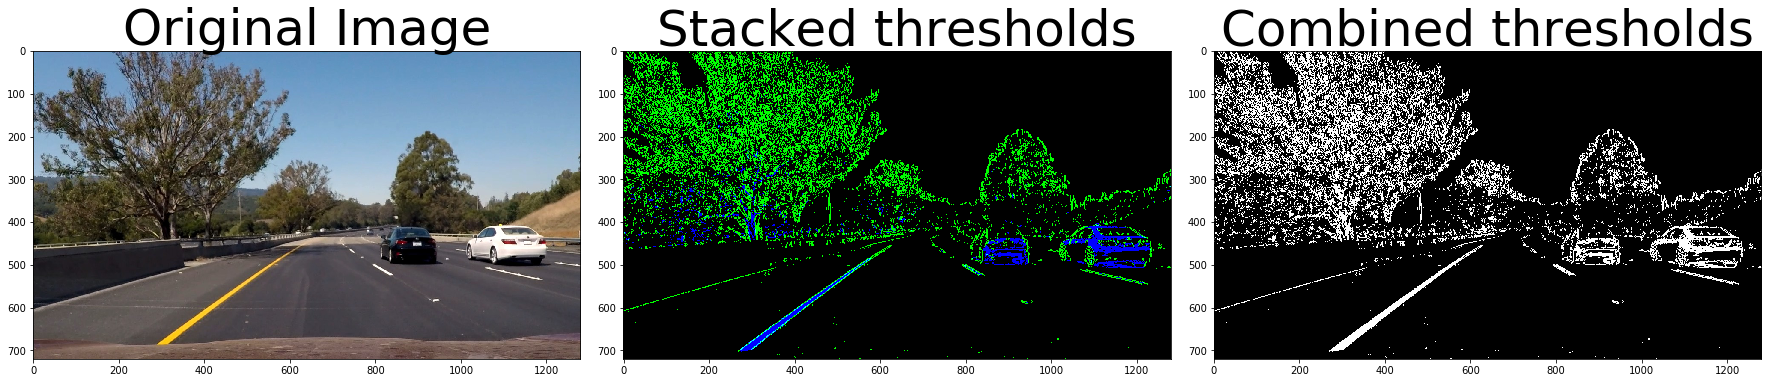

In [51]:
# create pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):

    # Convert to HLS color space and separate the L and S channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #print(hls.shape)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1


    return color_binary, combined_binary

#img = mpimg.imread('test_images/straight_lines1.jpg')
img = mpimg.imread('test_images/test6.jpg')

undistorted = cal_undistort(img, mtx, dist)
color_binary, combined_binary = pipeline(undistorted)

# Plot stacked threshold and combined threshold images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,9))
f.tight_layout()
ax1.set_title('Original Image', fontsize=50)
ax1.imshow(img)
ax2.set_title('Stacked thresholds', fontsize=50)
ax2.imshow(color_binary)
ax3.set_title('Combined thresholds', fontsize=50)
ax3.imshow(combined_binary, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Performed a perspective transform
####3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warper()`.  The `warper()` function takes as input an undistorted image. I chose the hardcode the source and destination points. I verified that my perspective transform was working as expected by drawing the test image and its warped counterpart to verify that the lines appear parallel in the warped image. The warped image is shown below.

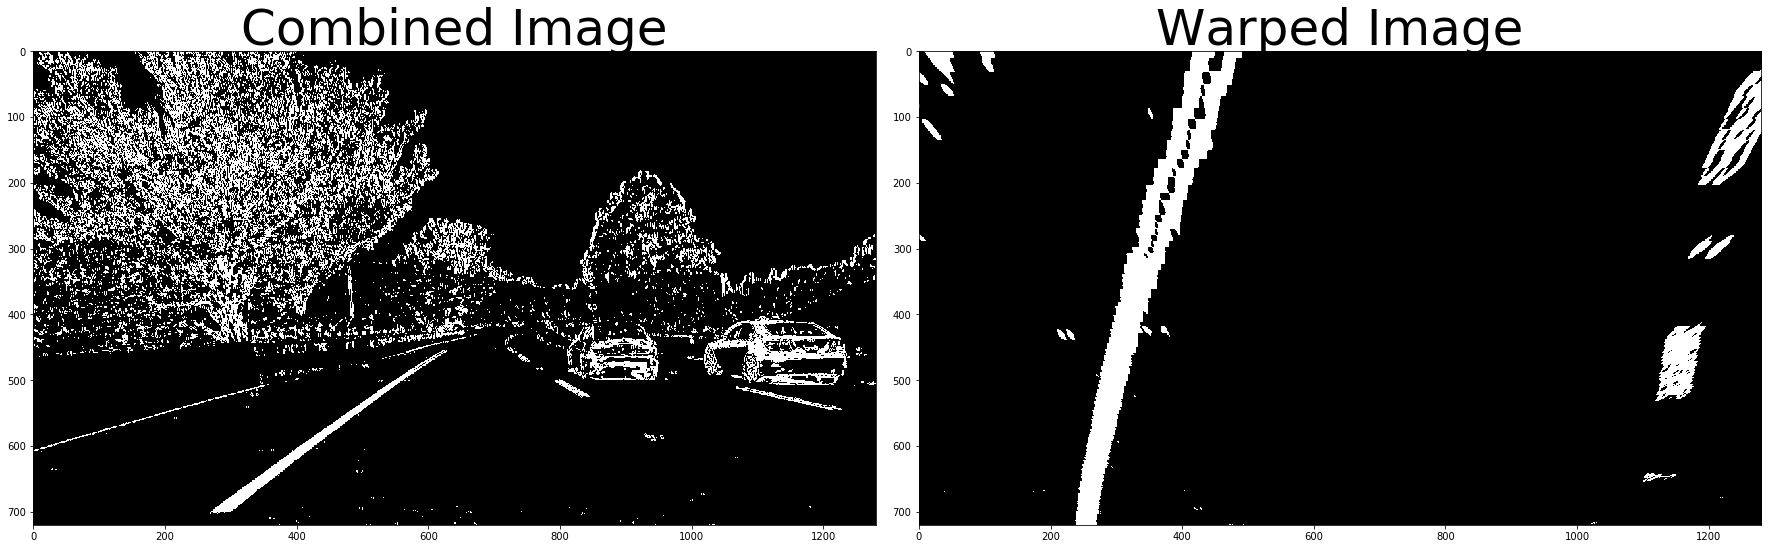

In [62]:
#perspective transform
def warper(undist):
    
    img_size = (undist.shape[1], undist.shape[0])

    src = np.float32(
    [[580, 460],
     [700, 460],
     [1040, 680],
     [260, 680]])
   
    dst = np.float32(
    [[200, 0],
     [1040, 0],
     [1040,720],
     [200,720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    return warped, M, Minv

binary_warped, perspective_M, Minv = warper(combined_binary)
 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Combined Image', fontsize=50)
ax1.imshow(combined_binary, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Histogram of lane pixels 

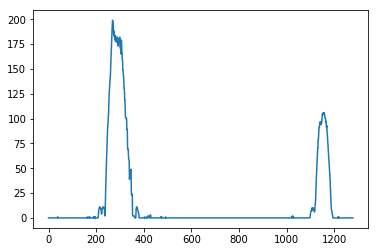

In [63]:
def display_hist(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    return

display_hist(binary_warped)

## Identified lane-line pixels and fit their positions with a polynomial
####4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

I used the 2nd order polynomial to identify the lane-line pixels in the polyfit function below.


## Determine the curvature of the lane and vehicle position with respect to center.
####5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I used the lane-line pixles to calculate the curvature in real world space. The code is identified under the Curvature comment.

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Finally, I visualized the sliding window and the selection window below.

Left Curvature:  983.31   Right Curvature:  1174.66
Offset right of Center:  1.21


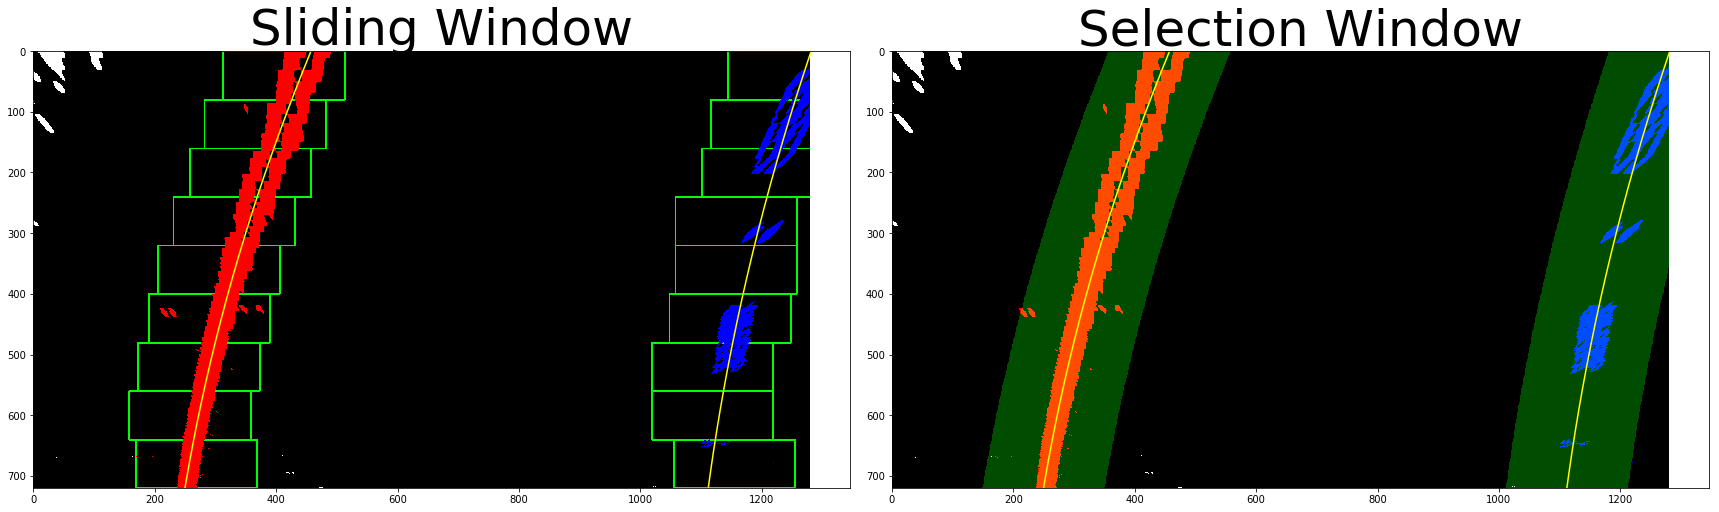

In [64]:
def poly_fit(binary_warped, out):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if lefty.size > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if righty.size > 0:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
      
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if (out==True):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.set_title('Sliding Window', fontsize=50)
        ax1.imshow(out_img)
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='yellow')

    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    if (out==True):
        ax2.set_title('Selection Window', fontsize=50)
        ax2.imshow(result)
        ax2.plot(left_fitx, ploty, color='yellow')
        ax2.plot(right_fitx, ploty, color='yellow')

    
    #curvature
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    rightx = right_fitx[::-1] # Reverse to match top-to-bottom in yield
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    # Compute car position
    car_pos = (((left_fitx[0] + right_fitx[0]) / 2)-(binary_warped.shape[1] / 2))*xm_per_pix
    
    if (out==True):
        print('Left Curvature: ', left_curverad.round(2), '  Right Curvature: ', right_curverad.round(2))
        print('Offset right of Center: ', car_pos.round(2))
    
    return ploty, left_fitx, right_fitx, left_curverad, right_curverad, car_pos

    
ploty, left_fitx, right_fitx, left_curverad, right_curverad, car_pos = poly_fit(binary_warped, True)


## Paint the road
## Warp the detected lane boundaries back onto the original image.
####6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

The code and image is provided below.

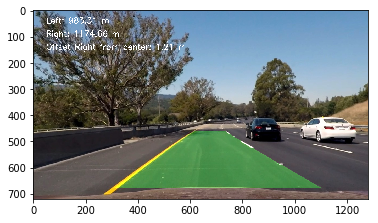

In [65]:
def final_image(ploty, left_fitx, right_fitx, left_curverad, right_curverad, car_pos, binary_warped, undistorted):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    # Annotate image with text
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Left: {:.2f} m".format(left_curverad)
    cv2.putText(result, text, (50,50), font, 1, (255,255,255), 2)
    text = "Right: {:.2f} m".format(right_curverad)
    cv2.putText(result, text, (50,100), font, 1, (255,255,255), 2)
    text = "Offset Right from center: {:.2f} m".format(car_pos)
    cv2.putText(result, text, (50,150), font, 1, (255,255,255), 2)

    #return final_output
    return result

result = final_image(ploty, left_fitx, right_fitx, left_curverad, right_curverad, car_pos, binary_warped, undistorted)
plt.imshow(result)

## Run the video images through the pipeline
###Pipeline (video)

####1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!). 

The final video (P4_video.mp4) is provided.

In [66]:
def process_image(img):
    #video pipeline
    undistorted = cal_undistort(img, mtx, dist)
    color_binary, combined_binary = pipeline(undistorted)
    binary_warped, perspective_M, Minv = warper(combined_binary)
    ploty, left_fitx, right_fitx, left_curverad, right_curvedrad, car_pos = poly_fit(binary_warped, False)
    result = final_image(ploty, left_fitx, right_fitx, left_curverad, right_curvedrad, car_pos, binary_warped, undistorted)
    return result
    

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_video_output = ('P4_video.mp4')
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video P4_video.mp4
[MoviePy] Writing video P4_video.mp4


100%|█████████▉| 1260/1261 [04:19<00:00,  4.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P4_video.mp4 

CPU times: user 4min 17s, sys: 1min 30s, total: 5min 48s
Wall time: 4min 21s


## Discussion
Here are the salient points:
1. This code should be optimized. Just ran out of time!
2. Many approaches (Convnets, for example) were not even attempted.
3. Challenge problems were not even attempted.
4. Need to develop better debugging techniques (to view intermediate results, for example).
5. This project was a humbling experience. I wish I could work on it full time!!